In [ ]:
#### Just some initalization work and imports 

In [4]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

x = [1, 2, 10, 5, 6, 4, 8, 0]
y = [3, 5, 4, 1, 2, 7, 3, 6]
# axis 0 is vertical, axis 1 is horizontal
coords = np.vstack((x, y)).transpose() # data points
dist_matrix = [] # distance matrix
dist_matrix_indices = [[i+1] for i in range(0,coords.shape[1])] #np.arange(1, coords.shape[1] + 1, dtype=np.dtype( (np.int32, (1,)) )) # 2d list that corresponds to the distance matrix axes
linkage_matrix = np.zeros((coords.shape[1] - 1, 4), dtype=np.float32) # the matrix containing merge data, for now this will hold [[M, N, min_distance]...]
cluster_merges_matrix = np.zeros((coords.shape[1] - 2, coords.shape[1] - 2), dtype=np.int32)  # 2D list of indices that correspond to merged clusters
print(f"coords\n{coords}\n\ndist_matrix_indices\n{dist_matrix_indices}\n\nlinkage_matrix\n{linkage_matrix}\n\ncluster_merges_matrix\n{cluster_merges_matrix}")


coords
[[ 1  3]
 [ 2  5]
 [10  4]
 [ 5  1]
 [ 6  2]
 [ 4  7]
 [ 8  3]
 [ 0  6]]

dist_matrix_indices
[[1], [2]]

linkage_matrix
[[0. 0. 0. 0.]]

cluster_merges_matrix
[]


### Compute initial proximity matrix from coordinates
#### A symmetric matrix has an interesting property, $A_ij = A_ji$
#### Another cool thing is you can create a symmetric matrix by computing its upper or lower triangle
#### then adding the matrix to a transposed matrix of itself
#### $A + A^T =$ a fully symmetrical matrix

In [7]:
def create_dist_matrix(coords: np.ndarray) -> np.ndarray:
    row_length = coords.shape[0]                          # row size, column size of input coordinates
    dist_triu_indices = np.triu_indices(row_length, 1)            # indices of the upper triangle above the diagonal in the matrix
    dist_matrix = np.zeros((row_length, row_length), dtype=np.float32) # init a (y_dim x y_dim) size proximity matrix with all zeros
    distances = []
    
    for i in range(row_length - 1):                  # iterate through all coordinates except the last one
        x1, y1 = coords[i]                            # select ith column of X coordinates
        for x2, y2 in coords[i+1:row_length]:   # select both x,y rows, then select columns ith + 1 to the last column
            # for presentation, floats are truncated to 3 decimal spaces
            distances.append( float('%.3f' % np.sqrt(np.square(x2 - x1) + np.square(y2 - y1)))  )
    dist_matrix[dist_triu_indices] = distances                # place all the calculated distances in the upper triangle of matrix
    return dist_matrix + dist_matrix.transpose()              # add the matrix itself to a transpose matrix of itself for symmetrical matrix
    
dist_matrix = create_dist_matrix(coords)
dist_matrix
# array([[ 0.   ,  2.236,  9.055,  4.472,  5.099,  5.   ,  7.   ,  3.162],
#        [ 2.236,  0.   ,  8.062,  5.   ,  5.   ,  2.828,  6.325,  2.236],
#        [ 9.055,  8.062,  0.   ,  5.831,  4.472,  6.708,  2.236, 10.198],
#        [ 4.472,  5.   ,  5.831,  0.   ,  1.414,  6.083,  3.606,  7.071],
#        [ 5.099,  5.   ,  4.472,  1.414,  0.   ,  5.385,  2.236,  7.211],
#        [ 5.   ,  2.828,  6.708,  6.083,  5.385,  0.   ,  5.657,  4.123],
#        [ 7.   ,  6.325,  2.236,  3.606,  2.236,  5.657,  0.   ,  8.544],
#        [ 3.162,  2.236, 10.198,  7.071,  7.211,  4.123,  8.544,  0.   ]])

array([[ 0.   ,  2.236,  9.055,  4.472,  5.099,  5.   ,  7.   ,  3.162],
       [ 2.236,  0.   ,  8.062,  5.   ,  5.   ,  2.828,  6.325,  2.236],
       [ 9.055,  8.062,  0.   ,  5.831,  4.472,  6.708,  2.236, 10.198],
       [ 4.472,  5.   ,  5.831,  0.   ,  1.414,  6.083,  3.606,  7.071],
       [ 5.099,  5.   ,  4.472,  1.414,  0.   ,  5.385,  2.236,  7.211],
       [ 5.   ,  2.828,  6.708,  6.083,  5.385,  0.   ,  5.657,  4.123],
       [ 7.   ,  6.325,  2.236,  3.606,  2.236,  5.657,  0.   ,  8.544],
       [ 3.162,  2.236, 10.198,  7.071,  7.211,  4.123,  8.544,  0.   ]],
      dtype=float32)

### find minimum points from proximity matrix

In [288]:
def find_min_points(prox_matrix: np.ndarray) -> tuple:
   upper_triangle = np.triu(prox_matrix)    # grab the upper triangle from distance matrix
   # print(upper_triangle)
   min_values = upper_triangle[ ~(upper_triangle == 0.0) ].min()  # ignore values equal to 0.0, find minimum values
   min_points = np.vstack(np.where(upper_triangle == min_values))[ :,0 ] # get the indices of those minimum values, stack the two resulting arrays
                                                         # and grab the first column, which will be the first found min_points
   return (*min_points, prox_matrix[ (*min_points), ])   # combine the min points with min distance, so we get [min_x, min_y, min_distance] 

min_points = find_min_points(dist_matrix)
min_points

(3, 4, 1.414)

In [ ]:
#### update the proximity matrix
The important part of this algorithm is determining which update method to use
$min=min(dist(P_1, P_i),dist(P_2, P_j))$<br><br>
or just let NumPy do the math! 

In [264]:
def update_dist_matrix(prox_matrix: np.ndarray, min_points: tuple) -> np.ndarray:
    result = np.amin(prox_matrix[min_points,:], axis=0) # merges the two min_points rows into one row by min values

    # print(f"\nAfter merging rows {min_points} together\n\t{result}\n")

    prox_matrix[ min_points[0] ] = result   # select min_points[0] row, set equal to min values
    prox_matrix[ :,min_points[0] ] = result # select all rows, select column min_points[0], set equal to min values
    prox_matrix = np.delete( prox_matrix, min_points[1], axis=0) # delete the jth row
    prox_matrix = np.delete( prox_matrix, min_points[1], axis=1) # delete the jth column

    return prox_matrix

dist_matrix = update_dist_matrix(dist_matrix, min_points)
dist_matrix

array([[ 0.   ,  2.236,  9.055,  4.472,  5.   ,  7.   ,  3.162],
       [ 2.236,  0.   ,  8.062,  5.   ,  2.828,  6.325,  2.236],
       [ 9.055,  8.062,  0.   ,  4.472,  6.708,  2.236, 10.198],
       [ 4.472,  5.   ,  4.472,  0.   ,  5.385,  2.236,  7.071],
       [ 5.   ,  2.828,  6.708,  5.385,  0.   ,  5.657,  4.123],
       [ 7.   ,  6.325,  2.236,  2.236,  5.657,  0.   ,  8.544],
       [ 3.162,  2.236, 10.198,  7.071,  4.123,  8.544,  0.   ]])

In [ ]:
def create_linkage_node(linkage_matrix, cluster_merges_matrix, (M,N)):
    ## pretty much, check if length at cluster merges[M] and N are greater than 2

### Merge and pair functions
```python
Dist Matrix Indices [[1], [2], [3], [4], [5], [6], [7], [8]]
Min Points (3, 4)

[[ 0.     2.236  9.055  4.472  5.099  5.     7.     3.162]
 [ 0.     0.     8.062  5.     5.     2.828  6.325  2.236]
 [ 0.     0.     0.     5.831  4.472  6.708  2.236 10.198]
 [ 0.     0.     0.     0.     1.414  6.083  3.606  7.071]
 [ 0.     0.     0.     0.     0.     5.385  2.236  7.211]
 [ 0.     0.     0.     0.     0.     0.     5.657  4.123]
 [ 0.     0.     0.     0.     0.     0.     0.     8.544]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]
Merged MN: [4, 5]


Dist Matrix Indices [[1], [2], [3], [4, 5], [6], [7], [8]]
Min Points (0, 1)

[[ 0.     2.236  9.055  4.472  5.     7.     3.162]
 [ 0.     0.     8.062  5.     2.828  6.325  2.236]
 [ 0.     0.     0.     4.472  6.708  2.236 10.198]
 [ 0.     0.     0.     0.     5.385  2.236  7.071]
 [ 0.     0.     0.     0.     0.     5.657  4.123]
 [ 0.     0.     0.     0.     0.     0.     8.544]
 [ 0.     0.     0.     0.     0.     0.     0.   ]]
Merged MN: [1, 2]


Dist Matrix Indices [[1, 2], [3], [4, 5], [6], [7], [8]]
Min Points (0, 5)

[[ 0.     8.062  4.472  2.828  6.325  2.236]
 [ 0.     0.     4.472  6.708  2.236 10.198]
 [ 0.     0.     0.     5.385  2.236  7.071]
 [ 0.     0.     0.     0.     5.657  4.123]
 [ 0.     0.     0.     0.     0.     8.544]
 [ 0.     0.     0.     0.     0.     0.   ]]
Merged MN: [1, 2, 8]


Dist Matrix Indices [[1, 2, 8], [3], [4, 5], [6], [7]]
Min Points (1, 4)

[[0.    8.062 4.472 2.828 6.325]
 [0.    0.    4.472 6.708 2.236]
 [0.    0.    0.    5.385 2.236]
 [0.    0.    0.    0.    5.657]
 [0.    0.    0.    0.    0.   ]]
Merged MN: [3, 7]


Dist Matrix Indices [[1, 2, 8], [3, 7], [4, 5], [6]]
Min Points (1, 2)

[[0.    6.325 4.472 2.828]
 [0.    0.    2.236 5.657]
 [0.    0.    0.    5.385]
 [0.    0.    0.    0.   ]]
Merged MN: [3, 7, 4, 5]


Dist Matrix Indices [[1, 2, 8], [3, 7, 4, 5], [6]]
Min Points (0, 2)

[[0.    4.472 2.828]
 [0.    0.    5.385]
 [0.    0.    0.   ]]
Merged MN: [1, 2, 8, 6]

# if the child[M or N] is greater than 1, grab the index of that child in children, add the len(coords) to that and set linkage[i] to that
# else grab child[M or N], subtract 1, and set linkage[i] to that
children
[
    [4 5]
    [1 2]
    [1 2 8]
    [3 7]
    [3 7 4 5]
    [1 2 8 6]
]

linkage
[
    [3 4] [2]
    [0 1] [2]
    [9 7] [3]
    [2 6] [2]
    [11 8] [4]
    [10 5] [4]
    [13 12] [8]
]
```

In [265]:
def merge(cluster_children: list, clusters: list, cluster_length: int, min_points: tuple):
   M, N = min_points
   mergedMN = [0,0]
   # we need to build [xdi, ydi, dist, leaf_count]   
   # yeah you could write this as a list comprehension, but oh well 
   for point in min_points:
      if len(clusters[point]) > 1:
         mergedMN[point] = cluster_children.index(clusters[point]) + cluster_length # len of coords somehow
      else:
         mergedMN[point] = clusters[point] - 1
         
   clusters[M].extend(clusters[N])
   clusters.remove(clusters[N])
   num_children = len(clusters[M]) # number of leaves or children for this new cluster

   return ( mergedMN, num_children )

def pair(merges):
   coordinates = []
   for merge in merges:
      coordinates.append([min(merge), max(merge)])
   return coordinates


### Then you can build a loop to calculate the distances

In [266]:
dist_matrix = create_dist_matrix(coords)

for i in range(coords.shape[1] - 2): # a 2x2 matrix means theres only 1 cluster left, that will be the root cluster
   M, N, min_dist = find_min_points(dist_matrix)
   print(f"\nDist Matrix Indices {dist_matrix_indices}")
   print(f"Min Points and Min Distance {M, N, min_dist}\n")
   print(np.triu(dist_matrix))
   mergedMN = merge(M, N, dist_matrix_indices) ## could integrate mergedMN in this function and maybe rename to merge_cluster_indices
   
   # merges_indices.append(mergedMN)
   cluster_merges_matrix[ i,:len(mergedMN) ] = mergedMN

   update_linkage_matrix(linkage_matrix, cluster_merges_matrix, (M,N))
   # print(f"Merged MN: {mergedMN}\n")
   linkage_matrix[i] = ( M, N, dist_matrix[ M, N ], 0 )   # update the merge matrix with min_point_x, min_point_y, min_distance
   dist_matrix = update_dist_matrix( dist_matrix, (M, N), )

coordinates = pair(merges_indices)
print(f"Cluster Merges Matrix\n\n{cluster_merges_matrix}\n")
# print(f"Paired Merged Indices\n\n{coordinates}")


Dist Matrix Indices [[1], [2], [3], [4], [5], [6], [7], [8]]
Min Points (3, 4)

[[ 0.     2.236  9.055  4.472  5.099  5.     7.     3.162]
 [ 0.     0.     8.062  5.     5.     2.828  6.325  2.236]
 [ 0.     0.     0.     5.831  4.472  6.708  2.236 10.198]
 [ 0.     0.     0.     0.     1.414  6.083  3.606  7.071]
 [ 0.     0.     0.     0.     0.     5.385  2.236  7.211]
 [ 0.     0.     0.     0.     0.     0.     5.657  4.123]
 [ 0.     0.     0.     0.     0.     0.     0.     8.544]
 [ 0.     0.     0.     0.     0.     0.     0.     0.   ]]
Merged MN: [4, 5]


Dist Matrix Indices [[1], [2], [3], [4, 5], [6], [7], [8]]
Min Points (0, 1)

[[ 0.     2.236  9.055  4.472  5.     7.     3.162]
 [ 0.     0.     8.062  5.     2.828  6.325  2.236]
 [ 0.     0.     0.     4.472  6.708  2.236 10.198]
 [ 0.     0.     0.     0.     5.385  2.236  7.071]
 [ 0.     0.     0.     0.     0.     5.657  4.123]
 [ 0.     0.     0.     0.     0.     0.     8.544]
 [ 0.     0.     0.     0.     0.   

### The Linkage Matrix
All indices `idx >= len(X)` actually refer to the cluster formed in `Z[idx - len(X)]`.

This means that while index `149` corresponds to `X[149]` that idx 150 corresponds<br>to the cluster formed in `Z[0]`, idx `151` to `Z[1]`, `152` to `Z[2]`, ...

In [4]:
# [idx1, idx2, dist, sample_count]
linked = linkage(coords.T)
print(coords)
linked

# [3 4] [2]
# [0 1] [2]
# [9 7] [3]
# [2 6] [2]
# [11 8] [4]
# [10 5] [4]
# [13 12] [8]

[[ 1  2 10  5  6  4  8  0]
 [ 3  5  4  1  2  7  3  6]]


array([[ 3.        ,  4.        ,  1.41421356,  2.        ],
       [ 0.        ,  1.        ,  2.23606798,  2.        ],
       [ 7.        ,  9.        ,  2.23606798,  3.        ],
       [ 6.        ,  8.        ,  2.23606798,  3.        ],
       [ 2.        , 11.        ,  2.23606798,  4.        ],
       [ 5.        , 10.        ,  2.82842712,  4.        ],
       [12.        , 13.        ,  4.47213595,  8.        ]])

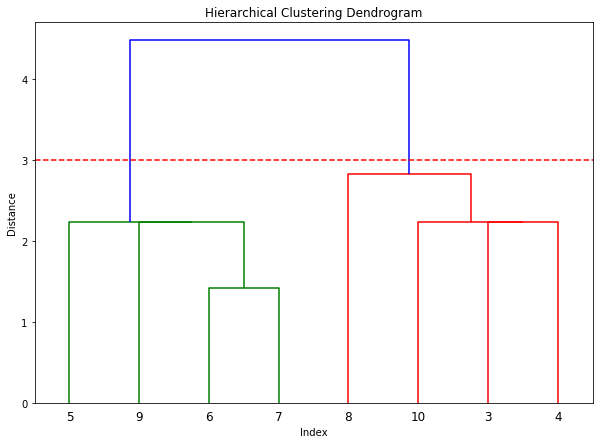

In [268]:
labelList = range(1, 11)

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.axhline(y=3.0, color='r', linestyle='--')
plt.show()

[2 2 1 1 1 2 1 2]


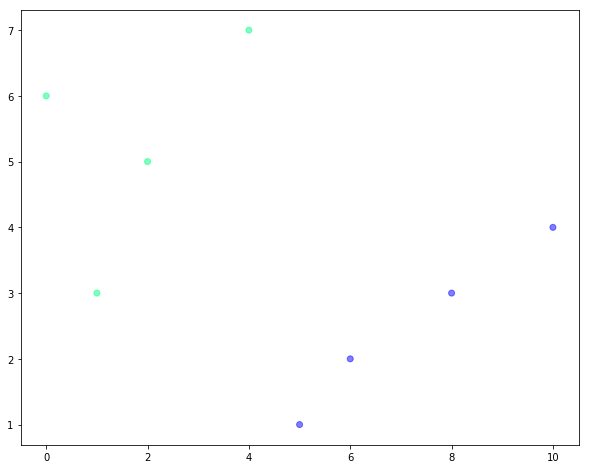

In [9]:
ex_clusters = fcluster(linked, 3.0, criterion="distance")
print(ex_clusters)
plt.figure(figsize=(10, 8))
plt.scatter(coords[0,:], coords[1,:], c=ex_clusters, cmap='winter', alpha=0.5)
plt.show()
# coords

### Playing with data from the files in the cells below

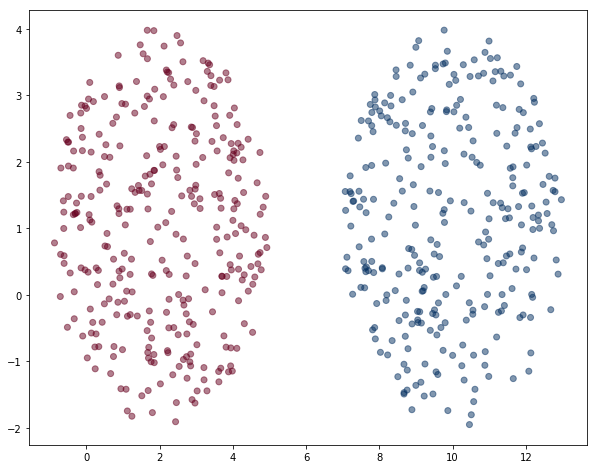

In [270]:
data1 = np.loadtxt("./data/data1.txt", delimiter=",")

plt.figure(figsize=(10, 8))
plt.scatter(data1[:,0], data1[:,1], c=data1[:,2], cmap='RdBu', alpha=0.5)
plt.show()

In [271]:
data1_linked = linkage(data1[ :,[1,2] ], "single")
data1_linked

array([[  18.     ,   57.     ,    0.00009,    2.     ],
       [  97.     ,  301.     ,    0.0001 ,    2.     ],
       [ 193.     ,  202.     ,    0.0001 ,    2.     ],
       ...,
       [ 441.     , 1223.     ,    0.1477 ,  293.     ],
       [ 544.     , 1224.     ,    0.1582 ,  294.     ],
       [1220.     , 1225.     ,    1.     ,  614.     ]])

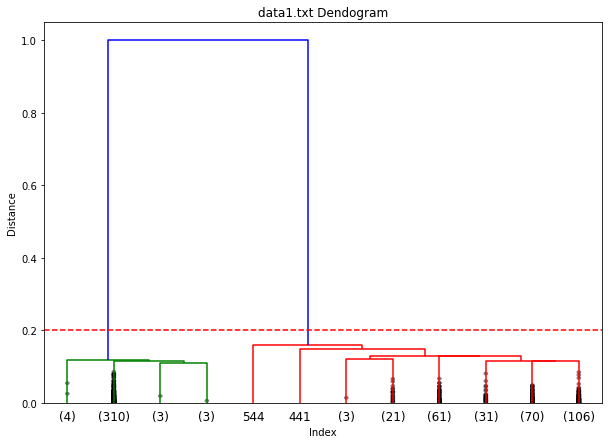

{'icoord': [[25.0, 25.0, 35.0, 35.0], [15.0, 15.0, 30.0, 30.0], [5.0, 5.0, 22.5, 22.5], [65.0, 65.0, 75.0, 75.0], [105.0, 105.0, 115.0, 115.0], [95.0, 95.0, 110.0, 110.0], [85.0, 85.0, 102.5, 102.5], [70.0, 70.0, 93.75, 93.75], [55.0, 55.0, 81.875, 81.875], [45.0, 45.0, 68.4375, 68.4375], [13.75, 13.75, 56.71875, 56.71875]], 'dcoord': [[0.0, 0.11050000000000004, 0.11050000000000004, 0.0], [0.0, 0.11590000000000034, 0.11590000000000034, 0.11050000000000004], [0.0, 0.11840000000000006, 0.11840000000000006, 0.11590000000000034], [0.0, 0.12129999999999996, 0.12129999999999996, 0.0], [0.0, 0.11460000000000004, 0.11460000000000004, 0.0], [0.0, 0.11519999999999975, 0.11519999999999975, 0.11460000000000004], [0.0, 0.12954999999999997, 0.12954999999999997, 0.11519999999999975], [0.12129999999999996, 0.12971999999999995, 0.12971999999999995, 0.12954999999999997], [0.0, 0.14769999999999994, 0.14769999999999994, 0.12971999999999995], [0.0, 0.1581999999999999, 0.1581999999999999, 0.1476999999999999

In [272]:
labelList = range(1, 11)

plt.figure(figsize=(10, 7))
plt.title('data1.txt Dendogram')
plt.xlabel('Index')
plt.ylabel('Distance')
dendrogram(data1_linked,
            truncate_mode="lastp",
            p=12,
            orientation='top',
            distance_sort='descending',
            show_contracted=True)
plt.axhline(y=0.2, color='r', linestyle='--')
plt.show()